# Introduction

DNA is one of the fundamental molecules of life.
A strand of DNA is comprised of a sequence of four molecules which are shortly named A, T, C or G. Two strands of DNA align alongside each other and form a twisted ladder called the double-helix (Fundamentals of Biochemistry: Life at the Molecular Level, 5th Edition, chapter 3).
The double helix has varying degrees of stiffness based on the sequence of its strands, so that one DNA molecule could be easier to bend compared to another. In this study, we use measurements of the angle between subsequent steps of a hexamer DNA from a molecular dynamics simulation trajectory.
The measurements were done using Curves+ program (Lavery R, Moakher M, Maddocks JH, Petkeviciute D, Zakrzewska K. Conformational analysis of nucleic acids revisited: Curves+. Nucleic Acids Res, 37 5917-29 (2014)). Simulation data is part of the ABC consortium (da Rosa, G., Grille, L., Calzada, V. et al. Sequence-dependent structural properties of B-DNA: what have we learned in 40 years?. Biophys Rev 13, 995–1005 (2021). https://doi.org/10.1007/s12551-021-00893-8).
In this dataset, bending angles between each two steps of the hexamer fragment is measured at 500,000 points along the simulation trajectory and the total bending of the fragment is also calculated.

# Building The Model

In [2]:
# Instaling Tsetlin Machine

!pip install pyTsetlinMachine

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachine: filename=pyTsetlinMachine-0.6.4-cp310-cp310-linux_x86_64.whl size=58747 sha256=401313757614600c0d705c7a13332d07e1bef63d97ea1edfd4958baeab6565ef
  Stored in directory: /root/.cache/pip/wheels/fb/a5/27/75f4c86a17c6bcb7c209a0923794840c2885e1e768523cec90
Successfully built pyTsetlinMachine


In [3]:
# Uploading database

from google.colab import files
uploaded = files.upload()

Saving DNA_Dataset1.csv to DNA_Dataset1.csv


In [4]:
from pyTsetlinMachine.tm import RegressionTsetlinMachine
from pyTsetlinMachine.tools import Binarizer
import pandas as pd
import numpy as np
from time import time

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import plotly.graph_objects as go

from pandas.io.feather_format import read_feather
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

*Categorizing the dataset columns into features and target.*
*   In this dataset, bending angles between each two steps of the hexamer fragment are considered as features and the total bending of the fragment is considered as the target.










In [5]:
# Reading the database file by Panda and assigninig to DNA_Dataset

DNA_Dataset = pd.read_csv('DNA_Dataset1.csv')

# An array of rational numbers corresponding to values of "total_bend" column
# An array of rational numbers corresponding to all the columns except "total_bend"
# A list of the column names
# Converting the data type of the variable "features" to float

target = DNA_Dataset['total_bend'].values.astype(float)
features = DNA_Dataset.drop(columns=['total_bend'])
feature_list = features.columns.tolist()
features = features.values.astype(float)

*Binarizing the data*

In [6]:
# An instance of the Binarizer class, with a maximum number of bits per feature set to 10.
# Calculate the thresholds for binarizing the input data by fit method.
# Binarizing based on the thresholds calculated in the previous step by transform method.

binary = Binarizer(max_bits_per_feature = 10)
binary.fit(features)
features_transformed = binary.transform(features)

The training and testing sets are typically used to evaluate the performance of a machine learning model. The model is trained on the training set and then tested on the testing set to see how well it generalizes to new data.
Random State ensures that the same random sequence is generated every time the function is run. This can be helpful for debugging and testing, as it allows you to ensure that the same results are obtained every time the function is called.

In [7]:
# Spliting data into two category of test and train with a test size of 20%

feature_train, feature_test, target_train, target_test = train_test_split(
	features_transformed, target, test_size=0.20, random_state=0)

# Checking synchronization of feature and target shapes.
print(feature_train.shape)
print(target_train.shape)

(3999, 50)
(3999,)


# Tsetlin Machine

*Finding the best number of clauses*
*   It defines a list of parameters called "param_list" which contains the number of clauses we will train our model with in order to find which number of clauses results in the most accurate prediction.
*   It then iterates over the values in "param_list"
*   creates a RegressionTsetlinMachine object, trains it using the "feature_train" and "target_train" data, and tests it using the "feature_test" and "target_test" data.
*   It appends the r-squared score of the predictions to the "result_list".
*   Finally, draw a ghraph for a better understanding. The graph represent the accuracy of prediction in each number of clauses in paeam_list







In [8]:
param_list = [1000, 2000, 3000, 5000, 10000]

result_list = []
for n_clause in param_list:
  print(n_clause)
  tm = RegressionTsetlinMachine(n_clause, 5000, 6, weighted_clauses=True)
  tm.fit(feature_train, target_train, epochs=20)
  y_pred =tm.predict(feature_test)
  result_list.append(r2_score(target_test, tm.predict(feature_test)))

fig = go.Figure(go.Scatter(x = param_list, y=result_list))
fig.show()

1000
2000
3000
5000
10000


*Initializing a Regression Tsetlin Machine.*
*   The machine has 1000 clauses, each with 5000 literals. The parameter 6 sets the threshold for activating the clauses. The machine uses a weighted average for its output since weighted_clauses is set to True.

In [9]:
tm = RegressionTsetlinMachine(2000, 500*10, 6, weighted_clauses=True)
tm.fit(feature_train, target_train, epochs=20)
tm_pred = tm.predict(feature_test)

*Evaluating the accuracy of Tsetlin Machine prediction by R Square*

In [10]:
tm_r2 = r2_score(target_test, tm.predict(feature_test))
tm_r2

0.9757025883314895

Evaluating the accuracy of Tsetlin Machine prediction by MSE

In [11]:
tm_mse = mean_squared_error(target_test, tm_pred, squared=False)
tm_mse

0.5413636453871872

Evaluating the accuracy of Tsetlin Machine prediction by MAPE

In [12]:
tm_mape = mean_absolute_percentage_error(target_test, tm_pred)
tm_mape

0.10495207724723876

# Random Forest


*   Using the Random Forest Regression algorithm to fit a model to training data.
*   Using that model to make predictions on test data.
*   n_estimators determines the number of decision trees that will be created in the forest.

In [13]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(feature_train, target_train)
rf_pred = rf.predict(feature_test)

Evaluating the accuracy of Random Forest prediction by R Square

In [14]:
rf_r2   = r2_score(target_test, rf_pred)
rf_r2

0.9913995385130089

Evaluating the accuracy of Random Forest prediction by MSE

In [15]:
rf_mse = mean_squared_error(target_test, rf_pred, squared=False)
rf_mse

0.3220845996024253

Evaluating the accuracy of Random Forest prediction by MAPE

In [16]:
rf_mape = mean_absolute_percentage_error(target_test, rf_pred)
rf_mape

0.05708982611745182

# Support Vector Machine for regression


*   Using SVR algorithm with a radial basis function (RBF) kernel.
*   It first fits the model on the training data (feature_train and target_train) and then predicts the target variable for the test data (feature_test) using the trained model.
*   The predicted values are stored in the svr_pred variable.

In [17]:
svr = SVR(kernel = 'rbf')
svr.fit(feature_train, target_train)
svr_pred = svr.predict(feature_test)

*Evaluating the accuracy of SVR prediction by R Square*

In [18]:
svr_r2   = r2_score(target_test, svr_pred)
svr_r2

0.9905586567600521

Evaluating the accuracy of SVR prediction by MSE

In [19]:
svr_mse = mean_squared_error(target_test, svr_pred, squared=False)
svr_mse

0.3374628541147918

Evaluating the accuracy of SVR prediction by MAPE

In [20]:
svr_mape = mean_absolute_percentage_error(target_test, svr_pred)
svr_mape

0.06887468850534677

# Conclusion

In this study we hypothesized that a mechine learning model should be able to learn bending of a DNA fragment after being trained on stepwise measurements along an MD trajectory. We trained and tested our data with three models: Tsetlin Machine, Random Forest and Support Vector Regression. Our resulting model is able to predict the bending of the DNA fragment with a high accuracy against the test data. This project can serve as a first step towards a generalized model for predicting DNA bending trained on comprehensive data set of various DNA sequences. The outcome of such model can have important applications in modeling protein-DNA interactions.

# Prediction Analysis

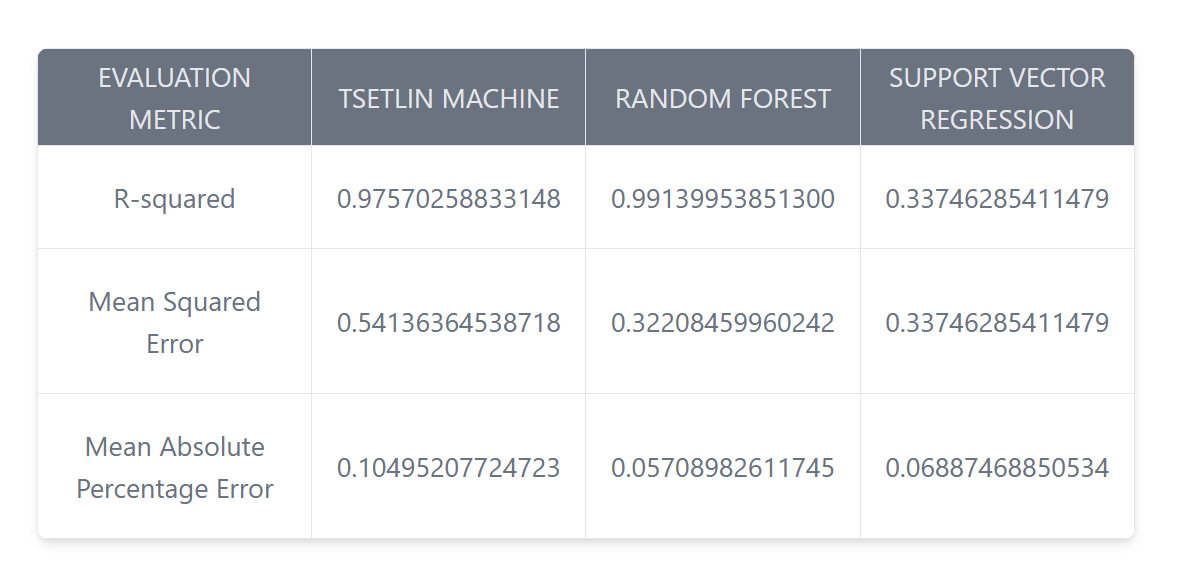
Based on the table, it can be observed that the Random Forest model outperforms the Tsetlin Machine and Support Vector Regression models in terms of R-Squared, MSE, and MAPE. The Random Forest model achieves the highest R-Squared value of 0.9914, indicating that it explains 99.14% of the variance in the data. Additionally, it has the lowest MSE value of 0.3221, indicating that it has the smallest average squared difference between predicted and actual values. Lastly, the Random Forest model also has the lowest MAPE value of 0.0571, suggesting that it has the smallest average percentage difference between predicted and actual values. These results indicate that the Random Forest model is the most accurate and precise in predicting the target variable compared to the Tsetlin Machine and Support Vector Regression models.

# References

*   Centre for Artificial Intelligence Research (CAIR). (2023) *pyTsetlinMachine*. Available at: https://github.com/cair/pyTsetlinMachine#tutorials (Accessed: 01.09.2023)

*   Rasgo. *How To Calculate r^2 with scikit-learn*. Available at: https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-r-2-with-scikit-learn (Accessed: 01.09.2023)

*   Dutta A. (2023) *Random Forest Regression in Python*. Available at: https://www.geeksforgeeks.org/random-forest-regression-in-python/ (Accessed: 01.09.2023)

*   Digitalboymksingh. (2023) *Support Vector Regression (SVR) using Linear and Non-Linear Kernels in Scikit Learn*. Available at: https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/ (Accessed: 01.09.2023)

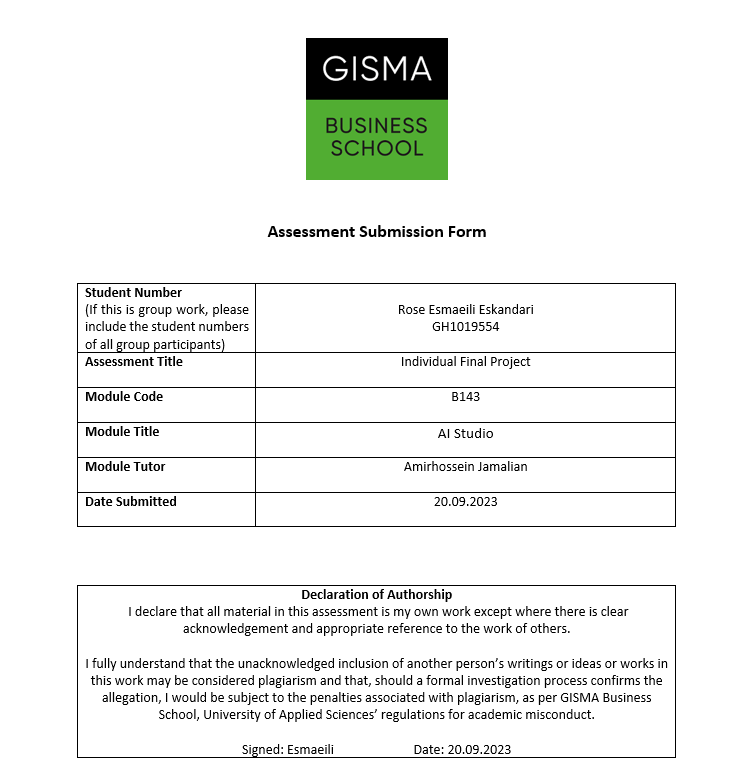